# Deep Unsupervised Learning HW1

## Warmup Exercise

In [9]:
import numpy as np
import torch
import torch.nn
import torch.utils.data
import matplotlib.pyplot as plt
import math

def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

def compute_loss(theta,x):
    #softmax
    _theta=torch.exp(theta) / torch.sum(torch.exp(theta))

    #instead of having a one hot encoded vector x, just use gather instead:
    prob = torch.gather(_theta, dim=0, index=x)

    loss = torch.sum(-torch.log2(prob))/prob.shape[0]
    return loss

## Create data and set parameters

In [2]:
sampled_data=sample_data()
n=len(sampled_data)
train_data = sampled_data[:int(0.6*n)]
val_data = sampled_data[int(0.6*n):int(0.8*n)]
test_data = sampled_data[int(0.8*n):]
batch_size=512
theta=torch.zeros(100,requires_grad=True)
optimizer = torch.optim.Adam([theta],lr=3e-4)
epochs=1000

Epoch 0: loss6.640065670013428 val_loss6.639639854431152 
Epoch 100: loss6.317140579223633 val_loss6.310300350189209 
Epoch 200: loss6.106627941131592 val_loss6.111555576324463 
Epoch 300: loss5.998766899108887 val_loss5.994115352630615 
Epoch 400: loss5.871201038360596 val_loss5.927525520324707 
Epoch 500: loss5.8062744140625 val_loss5.891590595245361 
Epoch 600: loss5.854290008544922 val_loss5.872189521789551 
Epoch 700: loss5.7515950202941895 val_loss5.861020088195801 
Epoch 800: loss5.860213756561279 val_loss5.854262351989746 
Epoch 900: loss5.874886512756348 val_loss5.850228786468506 


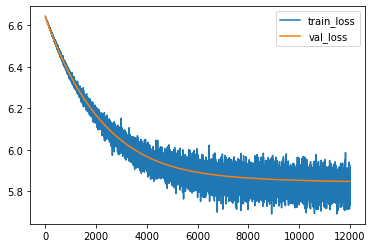

In [3]:
train_iter = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=val_data,batch_size=batch_size,shuffle=True)
losses = []
val_losses = []


for epoch in range(epochs):
    train_loss = 0

    for train_batch in train_iter:

        loss= compute_loss(theta,train_batch)

        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)

    with torch.set_grad_enabled(False):

        val_loss = compute_loss(theta,torch.from_numpy(val_data))
        val_losses.append(val_loss)
        
    if epoch % 100 ==0:
        print('Epoch {}: loss{} val_loss{} '.format(epoch,loss,val_loss))

import matplotlib.pyplot as plt
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()


In [4]:
test_iter = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True,num_workers=1)

# Compute Test Loss
for idx, test_batch in enumerate(test_iter):
    test_loss = compute_loss(theta, test_batch)



In [5]:
# Showing all losses
print("Final Training Loss:", losses[-1].item())
print("Final Validation Loss:", val_losses[-1].item())
print("Final Test Loss:", test_loss.item())



Final Training Loss: 5.927191257476807
Final Validation Loss: 5.84775447845459
Final Test Loss: 5.824062347412109


# Data distributions

Compute probability distribution

In [6]:
p = torch.exp(theta) / torch.sum(torch.exp(theta))
p = p.detach().numpy()

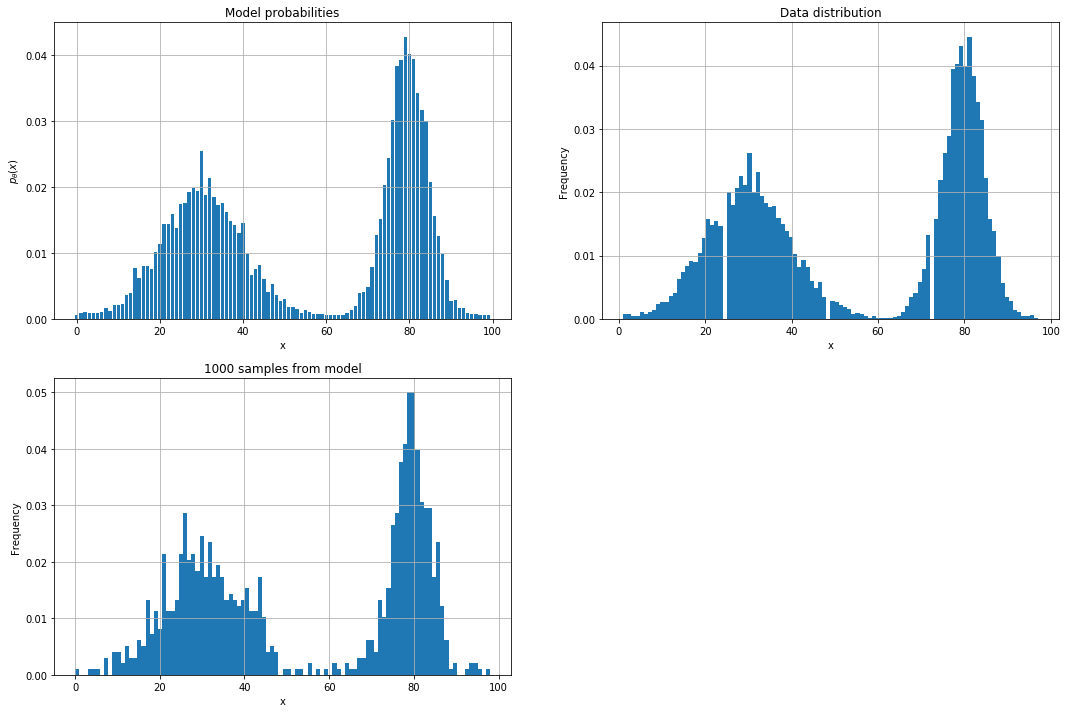

In [7]:

plt.figure(figsize=(18, 12))
plt.subplot(221)
plt.bar(np.arange(len(p)), p)
plt.title('Model probabilities')
plt.xlabel('x')
plt.ylabel('$p_{\\theta}(x)$')
plt.grid(True)


plt.subplot(222)
plt.hist(sampled_data, bins=100, density=True)
plt.title('Data distribution')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)


plt.subplot(223)
samples = np.random.choice(np.arange(100), p=p, size=1000)
plt.hist(samples, bins=100, density=True)
plt.title('1000 samples from model')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)

## Two dimensional data

In [2]:
probs = np.load('distribution.npy')

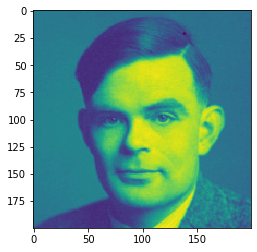

In [3]:
plt.imshow(probs)

In [4]:
samples = np.random.choice(np.arange(len(probs.ravel())), p=probs.ravel(), size=100000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train = samples[0:int(0.8*len(samples))]
test = samples[int(0.8*len(samples)):]



In [5]:
import seaborn

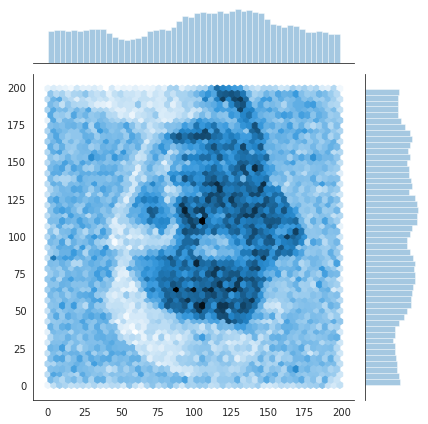

In [6]:
with seaborn.axes_style("white"):
    seaborn.jointplot(samples_x,samples_y,kind="hex")

In [7]:
batch_size=1000
n=200
from torch.autograd import Variable
theta=torch.zeros(n,requires_grad=True)
epochs=30

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Linear(n,n)
        self.fc2= nn.Linear(n,n)
        self.theta = nn.Parameter(torch.zeros(n,requires_grad=True))
        
    def forward(self, x):
        onehot = F.one_hot(x[:,0], num_classes=200)
        onehot = onehot.float()
        
        
        _theta=torch.exp(self.theta) / torch.sum(torch.exp(self.theta))
        prob = torch.gather(_theta,dim=0, index=x[:,0])

        prob2 = nn.functional.relu(self.fc(onehot))
        prob2 = nn.functional.relu(self.fc2(prob2))
        prob2 = nn.functional.softmax(prob2)
        
        prob2=torch.gather(prob2.T, dim=0, index=x[:,1].unsqueeze(0))

        return prob2, prob
    
    def loss(self, x):
        px2x1 ,px1 = self.forward(x)
        loss = -torch.sum(torch.log2(px1+1e-10) + torch.log2(px2x1+1e-10))/(2*px2x1.shape[1])
        
        return loss

net = MLP()


In [19]:
print(net)
optimizer = torch.optim.Adam(net.parameters(),lr=1e-3, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

MLP(
  (fc): Linear(in_features=200, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
)
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])


/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 7.63460636138916 val_loss 7.6360015869140625 
Epoch 10: loss 7.600871562957764 val_loss 7.617743015289307 
Epoch 20: loss 7.577333450317383 val_loss 7.6204423904418945 


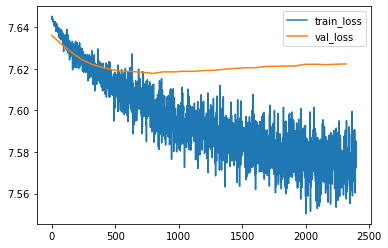

In [20]:
losses, val_losses =[],[]
train_iter = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size,shuffle=True)
losses = []
val_losses = []


for epoch in range(epochs):
    loss = 0

    for train_batch in train_iter:
        loss = net.loss(train_batch)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        del loss
        loss = 0
        
    with torch.set_grad_enabled(False):
        val_loss = net.loss(torch.from_numpy(test))
        val_losses.append(val_loss.data.numpy())
        
    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))

import matplotlib.pyplot as plt
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()


In [21]:
p1,p2 = net.forward(torch.from_numpy(test))
p1 = p1.detach().numpy()
p2 = p2.detach().numpy()

/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [22]:
net.theta
p1_theta = torch.exp(net.theta) / torch.sum(torch.exp(net.theta))
p1_theta = p1_theta.detach().numpy()

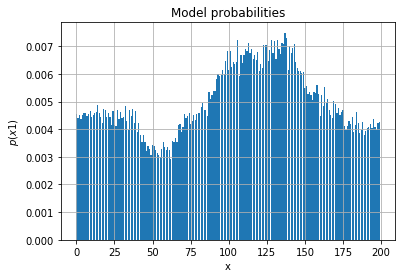

In [23]:
plt.bar(np.arange(len(p1_theta)), p1_theta)
plt.title('Model probabilities')
plt.xlabel('x')
plt.ylabel('$p_{}(x1)$')
plt.grid(True)

Data distribution probability

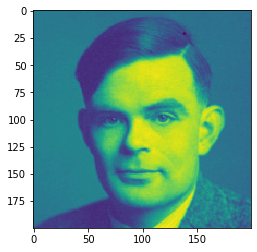

In [24]:
plt.imshow(probs)

Model probability

In [25]:
inp = [(x, y) for x in range(200) for y in range(200)]

/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


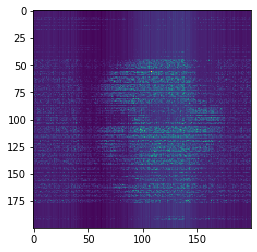

In [26]:
p_1,p_2=net.forward(torch.from_numpy(np.array(inp)))
sample_data = p_2*p_1
sample_data = sample_data.reshape(200,200).T.detach().numpy()
plt.imshow(sample_data)

## MADE

Check the paper again!

In [73]:
import torch.nn.functional as F
import torch.nn as nn
class MaskedLinear(nn.Linear):
    #Linear with mask
    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
    
class MADE(nn.Module):
    def __init__(self, hidden_sizes, natural_ordering=False):
        
        super().__init__()
        self.hidden_sizes = hidden_sizes
        
        #Compute h0
        layers = [MaskedLinear(n,hidden_sizes[0])]
        
        layers = []
        #compute h^l for l=1..L
        for m in range(0,len(hidden_sizes)-1):
            layers.append(nn.ReLU())
            layers.append(MaskedLinear(hidden_sizes[m], hidden_sizes[m+1]))
        layers.append(nn.ReLU())
        layers.append(MaskedLinear(hidden_sizes[-1], n))
        #compute x_hat

        self.net = nn.Sequential(*layers)
        self.softmax = nn.Softmax()
        
        self.seed = 0 
        self.m = []
        self.make_masks()
        
    def make_masks(self):
        L = len(self.hidden_sizes)
        
        #rng = np.random.RandomState(self.seed)
        #self.seed = (self.seed + 1)
        
        np.random.seed(self.seed)
        self.seed = (self.seed + 1)
        
        #sampling m^l vectors
        self.m.append(np.random.randint(0,high=n,size=n))
        for l in range(L):
            self.m.append(np.random.randint(self.m[l].min(),high=n,size=self.hidden_sizes[l]))
        
        # construct masks
        masks = [self.m[l][:,None] <= self.m[l+1][None,:] for l in range(L)]
        masks.append(self.m[L][:,None] < self.m[0][None,:])
                
        
        # multiply the masks on each linear layer
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        onehot1 = F.one_hot(x[:,0], num_classes=n).float()
        #print(F.one_hot(x, num_classes=n).float().reshape(-1,n*2)[0])
        #onehot = torch.cat((onehot1, onehot2), 1)
        out = self.net(onehot1)#.view(-1,2,n)
        sout=F.softmax(out)
        prob1 =torch.gather(sout.T, dim=0, index=x[:,0].unsqueeze(0))
        prob2 =torch.gather(sout.T, dim=0, index=x[:,1].unsqueeze(0))
        return prob2#prob1*prob2

    def loss(self, x):
        prob = self.forward(x)
        loss = -torch.sum(torch.log2(prob+1e-10))/(2*prob.shape[1])
        
        return loss
net = MADE([200,200])

In [74]:
print(net)
optimizer = torch.optim.Adam(net.parameters(),lr=3e-4, weight_decay=0.0001)
for param in net.parameters():
    print(type(param.data), param.size())

MADE(
  (net): Sequential(
    (0): ReLU()
    (1): MaskedLinear(in_features=200, out_features=200, bias=True)
    (2): ReLU()
    (3): MaskedLinear(in_features=200, out_features=200, bias=True)
  )
  (softmax): Softmax(dim=None)
)
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])
<class 'torch.Tensor'> torch.Size([200, 200])
<class 'torch.Tensor'> torch.Size([200])


/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0: loss 3.8199617862701416 val_loss 3.820059061050415 
Epoch 10: loss 3.8094072341918945 val_loss 3.810323476791382 
Epoch 20: loss 3.8022663593292236 val_loss 3.808671474456787 


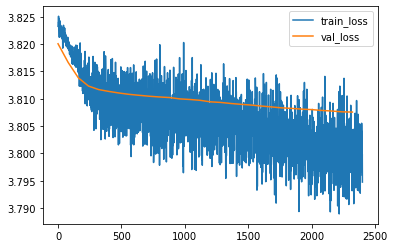

In [75]:
losses, val_losses =[],[]
train_iter = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=test,batch_size=len(test),shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0

    for train_batch in train_iter:
        loss = net.loss(train_batch)
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        
    with torch.set_grad_enabled(False):
        val_batch = next(iter(val_iter))
        val_loss = net.loss(val_batch)
        val_losses.append(val_loss.data.numpy())
        
    if epoch % 10 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))

import matplotlib.pyplot as plt
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()


/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


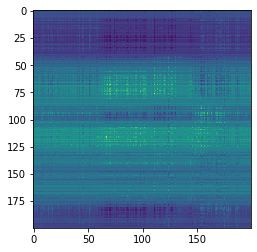

In [76]:
inp = [(x, y) for x in range(200) for y in range(200)]
prob=net.forward(torch.from_numpy(np.array(inp)))
prob=prob.reshape(200,200).T.detach().numpy()
plt.imshow(prob)

/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


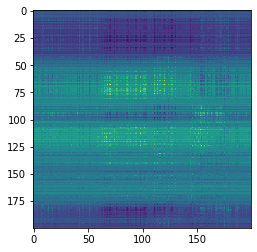

In [38]:
inp = [(x, y) for x in range(200) for y in range(200)]
prob=net.forward(torch.from_numpy(np.array(inp)))
prob=prob.reshape(200,200).T.detach().numpy()
plt.imshow(prob)

## High Dimensional data

In [10]:
import pickle

In [11]:
with open('mnist-hw1.pkl', 'rb') as f:
    data = pickle.load(f)

x_train = data['train'][:1000].astype('float32')


In [12]:
x_val = data['train'][1000:1100].astype('float32')


In [13]:
x_train[0].shape

(28, 28, 3)

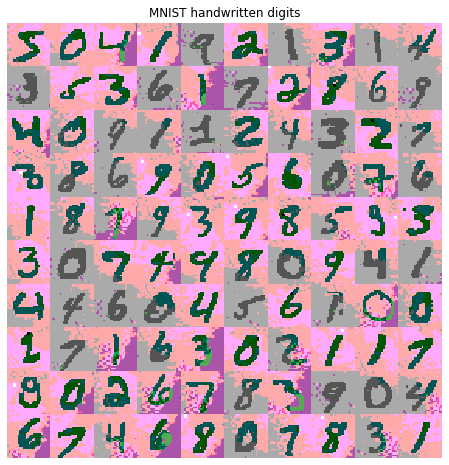

In [14]:
#plot a few MNIST examples
idx, dim, classes, rgb  = 0, 28, 10,3
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim ,rgb))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim, ] = x_train[idx]/rgb
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [15]:
x_train = torch.Tensor(x_train).permute(0,3,1,2)
x_val = torch.Tensor(x_val).permute(0,3,1,2)

PIXELCNN

In [16]:
import torch.nn as nn

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, channel_in, channel_out, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(channel_in, channel_out, kernel_size, stride, padding, bias=False)
        self.mask_type = mask_type
        channel_out, channel_in, height, width = self.weight.size()

        mask = torch.ones(channel_out, channel_in, height, width)
        
        if mask_type == 'A':
            mask[:, :, height // 2, width // 2:] = 0
            mask[:, :, height // 2 + 1:] = 0
        else:
            mask[:, :, height // 2, width // 2 + 1:] = 0
            mask[:, :, height // 2] = 0
        
        #dont let self.mask appear in model.parameters() as it would then  be updated
        self.register_buffer('mask', mask)


    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [17]:
class ResNetBlock(nn.Module):
    def __init__(self,channels=128):

        super(ResNetBlock,self).__init__()
        self.channels=channels

        self.network = nn.Sequential(nn.ReLU(),
        nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0), nn.ReLU(),
        MaskedConv2d('B',self.channels,self.channels, 3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0)
        )

    def forward(self,x):
        out= self.network(x)
        return x+out
        

In [18]:
class MaskedLinear(nn.Linear):
    #Linear with mask
    
    def __init__(self, in_features, out_features, bias=True,batch_size=128, mask_type='in'):
        super().__init__(in_features, out_features, bias)
        
        mask = torch.ones(batch_size, rgb, dim, dim, 4*rgb)
        
        if mask_type == 'in':
            mask[:,:,:,:,:rgb+1] = 0
            mask[:,0,:,:,-(rgb+1):] = 0
        else:
            mask = torch.ones(batch_size, rgb*4, dim, dim, rgb)
            mask[:,:,:,:,1]=0
            mask[:,rgb+1:,:,:,2]=0
            
            
        self.register_buffer('mask', torch.ones(out_features, in_features))

        
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)
    

In [153]:
mask=torch.ones(rgb, rgb*4)

In [158]:
mask[:,:rgb+1] = 0
mask[0,-(rgb+1):] = 0

In [ ]:
0000,1111,0000
0000,1111,1111
0000,1111,1111

In [159]:
mask

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [161]:
mask2=torch.ones(rgb*4, rgb)

In [ ]:
1111,1111,1111
0000,0000,0000
1111,0000,0000

In [163]:
mask2[:,1]=0
mask2[rgb+1:,2]=0

In [165]:
mask2.T

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [123]:
import torch.nn.functional as F
class PixelCNN(nn.Module):
    
    def __init__(self, num_layers=12,kernel=7,channels=128, final_channels=4):
        
        super(PixelCNN,self).__init__()
        self.num_layers=num_layers
        self.kernel=kernel
        self.channels=channels
        self.batch_size=1
        
        self.layers=[MaskedConv2d('A',3,self.channels*2, self.kernel, stride=1, padding=3)]
        for m in range(0, self.num_layers):
            self.layers.append(ResNetBlock(self.channels))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(2*self.channels,self.channels, 1, stride=1))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Conv2d(self.channels,rgb*final_channels, 1, stride=1))
        
        self.network = nn.Sequential(*self.layers)
        
        self.layer1 = MaskedLinear(rgb*4*dim*dim,rgb,True,self.batch_size,'in')

        self.layer2 = MaskedLinear(rgb,rgb*dim*dim*4,True,self.batch_size)
                
        
    def forward(self,x):
        self.batch_size = x.shape[0]
        x = self.network(x)
        x = x.view(self.batch_size, rgb, -1, dim, dim)

        # [batch_size, 3, 28, 28, 4]
        x = x.permute(0, 1, 3, 4, 2)
        return x
    
    def loss(self,x):
        #shouldn't we make made work here???
        x = self.MADE(x)
        prob = F.softmax(x,dim=-1)
        return prob
    
    def MADE(self,x):
        self.batch_size = x.shape[0]
        x = self.forward(x)       
        x = x.reshape(self.batch_size,-1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(self.batch_size,rgb,dim,dim,-1)
        
        return x
    
    def sample(self,batch_size):

        sample = torch.Tensor(np.random.choice(4, size=(batch_size, rgb, dim, dim)).astype(np.uint8))

        for i in range(dim):
            for j in range(dim):

                probs = pikzelSeNN.loss(sample).data
                probs = F.softmax(probs.float(),dim=-1)

                for k in range(3):
                    pixel = torch.multinomial(probs[:, k], 1).float()
                    sample[:, k, i, j] = pixel

        return sample
    

In [110]:
np.random.choice(4, p=[0.1,0.1,0.5,0.3])

0

In [124]:
pikzelSeNN = PixelCNN()

In [125]:
optimizer = torch.optim.Adam(pikzelSeNN.parameters(),lr=3e-4, weight_decay=0.0001)


In [126]:
def CEL(inp,out):
    return F.cross_entropy(inp,out)

In [127]:
batch_size = 50
epochs=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0: loss 1.388047456741333 val_loss 1.388033151626587 


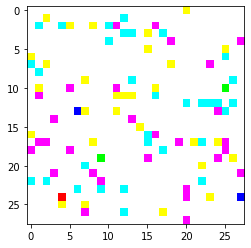

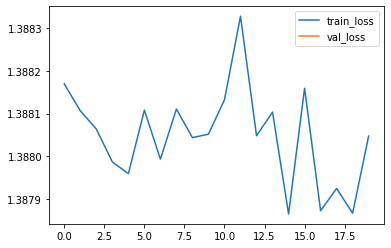

In [132]:
losses, val_losses =[],[]
train_iter = torch.utils.data.DataLoader(dataset=x_train,batch_size=batch_size,shuffle=True)
val_iter = torch.utils.data.DataLoader(dataset=x_val,batch_size=len(x_val),shuffle=True)
losses = []
val_losses = []

for epoch in range(epochs):
    train_loss = 0
    
    for train_batch in train_iter:
        loss = CEL(pikzelSeNN.loss(train_batch).reshape(-1,4,batch_size),train_batch.long().reshape(-1,batch_size))
        loss.backward()    
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.data.numpy())
        
    with torch.set_grad_enabled(False):
        val_batch = next(iter(val_iter))
        val_loss = CEL(pikzelSeNN.loss(val_batch).reshape(-1,4,len(x_val)),val_batch.long().reshape(-1,len(x_val)))
        val_losses.append(val_loss.data.numpy())
    plt.figure()
    plt.imshow(pikzelSeNN.sample(1).view(dim,dim,rgb))
        
    if epoch % 1 ==0:
        print('Epoch {}: loss {} val_loss {} '.format(epoch,losses[-1],val_losses[-1]))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses, label = "train_loss")
plt.plot(np.arange(0, len(losses),int(len(losses)/len(val_losses))),val_losses, label = "val_loss")
plt.legend()
plt.show()

In [129]:
sampel=pikzelSeNN.sample(1)

In [130]:
sampel

tensor([[[[26.,  8.,  9.,  ..., 13.,  4., 15.],
          [20., 13.,  2.,  ...,  6., 15.,  0.],
          [26.,  2., 10.,  ..., 19., 24.,  0.],
          ...,
          [26.,  4., 16.,  ...,  0., 25., 22.],
          [15., 10., 23.,  ..., 23.,  4., 14.],
          [27., 18., 24.,  ..., 15.,  4.,  6.]],

         [[ 1., 23., 27.,  ..., 17., 24., 12.],
          [ 7.,  7.,  7.,  ...,  5., 16., 21.],
          [ 0., 13.,  3.,  ..., 10., 27.,  8.],
          ...,
          [ 6.,  1., 20.,  ..., 24., 14.,  8.],
          [ 5., 10.,  6.,  ...,  1., 25., 14.],
          [ 7., 15., 25.,  ..., 21., 16., 13.]],

         [[16., 19., 26.,  ...,  5., 22.,  5.],
          [ 8.,  8., 16.,  ..., 13., 25., 15.],
          [25., 18., 24.,  ..., 18., 23.,  7.],
          ...,
          [ 7., 17., 26.,  ..., 27.,  1.,  9.],
          [ 4., 20., 25.,  ..., 21.,  2., 19.],
          [18., 10., 16.,  ...,  4., 22., 15.]]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


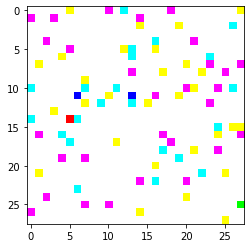

In [131]:
plt.imshow(sampel.view(dim,dim,rgb))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


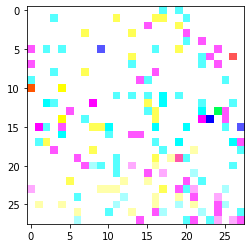

In [34]:
plt.imshow(sample(1).view(dim,dim,rgb))

In [38]:
pikzelSeNN.forward(x_train[0:2]).shape

torch.Size([2, 3, 28, 28, 4])

In [161]:
sampel=pikzelSeNN.sample(1)

/home/peter/anaconda3/envs/RL/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


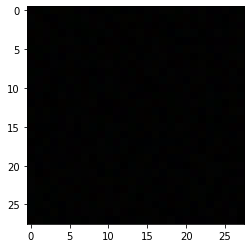

In [173]:
plt.imshow(sampel.view(dim,dim,rgb), cmap='gray')